# Run ephys element workflow

This notebook walks you through the steps to run the ephys workflow.  
The workflow requires neuropixels meta file and kilosort output data.  
A typical organization of the files is as follows:  

```
root_data_dir/
└───subject1/
│   └───session0/
│   │   └───imec0/
│   │   │   │   *imec0.ap.meta
│   │   │   └───ksdir/
│   │   │       │   spike_times.npy
│   │   │       │   templates.npy
│   │   │       │   ...
│   │   └───imec1/
│   │       │   *imec1.ap.meta   
│   │       └───ksdir/
│   │           │   spike_times.npy
│   │           │   templates.npy
│   │           │   ...
│   └───session1/
│   │   │   ...
└───subject2/
│   │   ...
```



Let's start by importing the relevant modules.

In [1]:
import datetime
import pathlib

import os
os.chdir('../..')

import datajoint as dj
from u19_pipeline import subject, acquisition, ephys
# from u19_pipeline.ephys_element import probe_element, ephys_element
from u19_pipeline.ephys import probe_element, ephys_element

dj.config['stores'] = {
    'extstorage':
    {
        'location': '/Volumes/u19_dj/external_dj_blobs',
        'protocol': 'file'
    }
}

Connecting ms81@datajoint00.pni.princeton.edu:3306


The module ephys_element contains all the tables designed in the DataJoint ephys element, we could draw the diagram to see the schema structures

In [2]:
# key = {"subject_fullname": "ms81_M004"}
# s = ephys.BehaviorSync() & key
# s.delete()

ephys.BehaviorSync()

# s.fetch('insertion_number')
# ephys.BehaviorSync() & key

# ephys.CuratedClustersIteration()
 #* BehaviorSync.ImecSamplingRate

subject_fullname username_mouse_nickname,session_date date of experiment,session_number number,nidq_sampling_rate sampling rate of behavioral iterations niSampRate in nidq meta file,iteration_index_nidq length of this longblob should be the number of iterations in the behavior recording,trial_index_nidq length of this longblob should be the number of iterations in the behavior recording
hnieh_E105,2021-01-15,0,5000.08,=BLOB=,=BLOB=


In [4]:
ephys.BehaviorSync.populate()

In [5]:
ephys.BehaviorSync()

subject_fullname username_mouse_nickname,session_date date of experiment,session_number number,nidq_sampling_rate sampling rate of behavioral iterations niSampRate in nidq meta file,iteration_index_nidq length of this longblob should be the number of iterations in the behavior recording,trial_index_nidq length of this longblob should be the number of iterations in the behavior recording
hnieh_E105,2021-01-15,0,5000.08,=BLOB=,=BLOB=
ms81_M004,2021-05-07,0,5000.06,=BLOB=,=BLOB=


In [23]:
session_dir = pathlib.Path('/Users/ms81/project_Neuropixel/analyses/data/210507_M004/')

In [24]:
imec_bin_filepath = list(session_dir.glob('*imec{}/*.ap.meta'.format(0)))

In [29]:
s

'/Users/ms81/project_Neuropixel/analyses/data/210507_M004/towersTask_g0_imec0/towersTask_g0_tcat.imec0.ap.meta'

In [42]:
list(session_dir.glob('*imec0*'))

[PosixPath('/Users/ms81/project_Neuropixel/analyses/data/210507_M004/towersTask_g0_imec0')]

In [43]:
list(session_dir.glob('*imec{}/*.ap.meta'.format(0)))

[PosixPath('/Users/ms81/project_Neuropixel/analyses/data/210507_M004/towersTask_g0_imec0/towersTask_g0_tcat.imec0.ap.meta')]

In [44]:
ephys_element.ProbeInsertion & key

subject_fullname username_mouse_nickname,session_date date of experiment,session_number number,insertion_number,probe unique identifier for this model of probe (e.g. part number)
ms81_M004,2021-05-07,0,0,19108323562
ms81_M004,2021-05-07,0,1,19108323362


In [33]:
ephys.BehaviorSync.populate()

DataJointError: fetch1 should only return one tuple. 0 tuples found

In [7]:
ephys_element.ProbeInsertion

element_array_ephys.ephys.ProbeInsertion

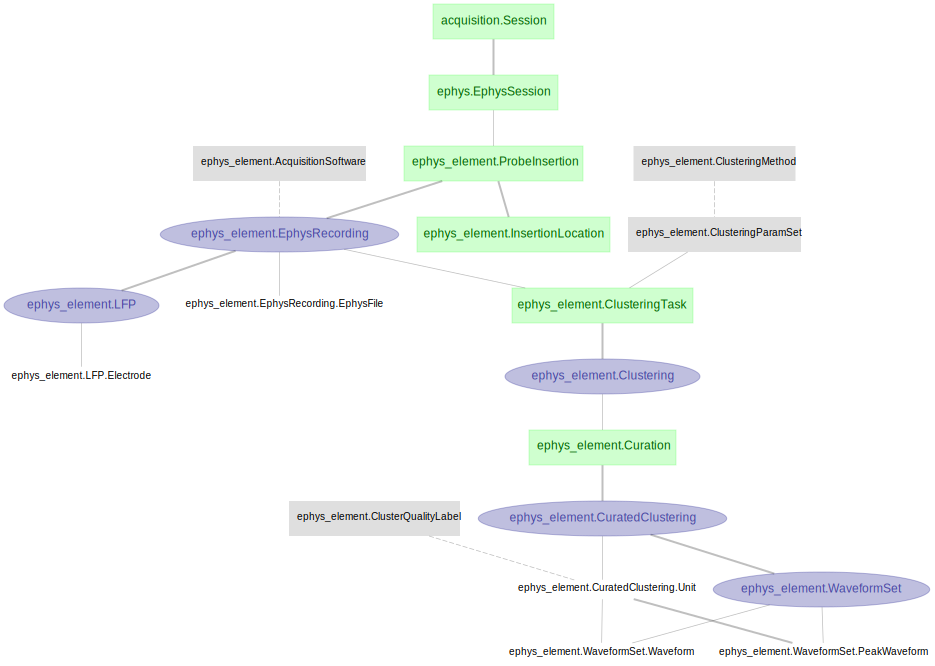

In [9]:
dj.Diagram(acquisition.Session) + ephys.EphysSession + dj.Diagram(ephys_element)

## Ingest Probe and ProbeInsertion by ephys_element_ingest

The original U19 pipeline contains a table `ephys.EphysSession` where datapath to the neuropixel meta file and the kilosort output folder were stored.

In [10]:
ephys.EphysSession()

subject_fullname username_mouse_nickname,session_date date of experiment,session_number number,ephys_directory Path were session file will be stored in bucket
hnieh_E105,2021-01-15,0,/mnt/bucket/labs/tank/schottdorf/NPX/2021_01_15_E105/towersTask_g0


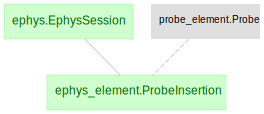

In [19]:
dj.Diagram(ephys.EphysSession) + dj.Diagram(probe_element.Probe) + dj.Diagram(ephys_element.ProbeInsertion)

A module `ephys_element_ingest` was provided to process a ephys session based on the neuropixel meta file: ingest entries into tables `Probe` and `ProbeInsertion`

In [17]:
import datetime
# lab = dj.create_virtual_module('lab', 'u19_lab') # the first argument here is the __name__ of the virtual module
# task = dj.create_virtual_module('task', 'u19_task') 
# subject = dj.create_virtual_module('subject', 'u19_subject')
# action = dj.create_virtual_module('action', 'u19_action')
# acquisition = dj.create_virtual_module('acquisition', 'u19_acquisition')
behavior = dj.create_virtual_module('behavior', 'u19_behavior')


In [10]:
key = {
    'subject_fullname': 'ms81_M004',
    'session_date': datetime.date(2021, 5, 7),
    'session_number': 0,
    'ephys_directory': '/Users/ms81/project_Neuropixel/analyses/data/210507_M004/'
}

In [61]:
ephys.EphysSession.insert1(key, skip_duplicates=True) # insert1 only works for one entry

In [12]:
ephys.EphysSession()

subject_fullname username_mouse_nickname,session_date date of experiment,session_number number,ephys_directory Path were session file will be stored in bucket
hnieh_E105,2021-01-15,0,/Volumes/Tank/schottdorf/NPX/2021_01_15_E105/towersTask_g0
ms81_M002,2021-05-04,0,/20210504/M002
ms81_M004,2021-05-07,0,/Users/ms81/project_Neuropixel/analyses/data/210507_M004/


In [63]:
# s = ephys.EphysSession() & key
# s.delete()
# ephys.EphysSession.populate(display_progress=True, suppress_errors=True, reserve_jobs=True)

In [42]:
from u19_pipeline.ingest import ephys_element_ingest

In [68]:
for sess_key in ephys.EphysSession.fetch('KEY'):
    ephys_element_ingest.process_session(sess_key)

In [69]:
probe_element.Probe()

probe unique identifier for this model of probe (e.g. part number),probe_type e.g. neuropixels_1.0,probe_comment
17131311651,neuropixels 1.0 - 3B,
19108323362,neuropixels 1.0 - 3B,
19108323562,neuropixels 1.0 - 3B,
19122511691,neuropixels 2.0 - MS,


In [13]:
ephys_element.ProbeInsertion()

subject_fullname username_mouse_nickname,session_date date of experiment,session_number number,insertion_number,probe unique identifier for this model of probe (e.g. part number)
hnieh_E105,2021-01-15,0,0,17131311651
ms81_M004,2021-05-07,0,1,19108323362
ms81_M004,2021-05-07,0,0,19108323562


## Populate EphysRecording

By populating `ephys_element.EphysRecording`, three tables will be ingested:
+ `probe_element.EelectrodeConfig` table contains the configuration information of the electrodes used, i.e. which 384 electrodes out of the total 960 on the probe were used in this ephys session
+ `ephys_element.EphysRecording` table specifies which ElectrodeConfig is used in a particular ephys session
+ `ephys_element.EphysRecording.EphysFile` table saves the file path of SpikeGLX meta file.

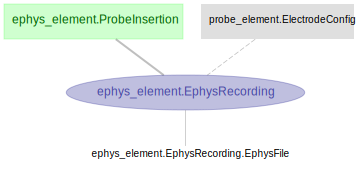

In [72]:
dj.Diagram(ephys_element.ProbeInsertion) + probe_element.ElectrodeConfig\
+ ephys_element.EphysRecording + ephys_element.EphysRecording.EphysFile

In [74]:
ephys_element.EphysRecording?

In [20]:
ephys_element.EphysRecording()

subject_fullname username_mouse_nickname,session_date date of experiment,session_number number,insertion_number,electrode_config_hash,acq_software,sampling_rate (Hz)
hnieh_E105,2021-01-15,0,0,6f6d8149-1603-9d2c-f884-0fdf995ec8b3,SpikeGLX,30000.6
ms81_M004,2021-05-07,0,0,6f6d8149-1603-9d2c-f884-0fdf995ec8b3,SpikeGLX,30000.7
ms81_M004,2021-05-07,0,1,6f6d8149-1603-9d2c-f884-0fdf995ec8b3,SpikeGLX,30000.7


In [15]:
ephys_element.EphysRecording.populate(display_progress=True)

EphysRecording: 0it [00:00, ?it/s]


Here is an overview of the Electrode used in a EphysRecording for a particular probe insertion

In [16]:
probe_insertion_key = ephys_element.ProbeInsertion.fetch('KEY', limit=2)[1]
probe_insertion_key

{'subject_fullname': 'ms81_M004',
 'session_date': datetime.date(2021, 5, 7),
 'session_number': 0,
 'insertion_number': 0}

In [17]:
ephys_element.EphysRecording * probe_element.ElectrodeConfig.Electrode & probe_insertion_key

subject_fullname username_mouse_nickname,session_date date of experiment,session_number number,insertion_number,electrode_config_hash,probe_type e.g. neuropixels_1.0,"electrode electrode index, starts at 0",acq_software,sampling_rate (Hz)
ms81_M004,2021-05-07,0,0,6f6d8149-1603-9d2c-f884-0fdf995ec8b3,neuropixels 1.0 - 3B,0,SpikeGLX,30000.7
ms81_M004,2021-05-07,0,0,6f6d8149-1603-9d2c-f884-0fdf995ec8b3,neuropixels 1.0 - 3B,1,SpikeGLX,30000.7
ms81_M004,2021-05-07,0,0,6f6d8149-1603-9d2c-f884-0fdf995ec8b3,neuropixels 1.0 - 3B,2,SpikeGLX,30000.7
ms81_M004,2021-05-07,0,0,6f6d8149-1603-9d2c-f884-0fdf995ec8b3,neuropixels 1.0 - 3B,3,SpikeGLX,30000.7
ms81_M004,2021-05-07,0,0,6f6d8149-1603-9d2c-f884-0fdf995ec8b3,neuropixels 1.0 - 3B,4,SpikeGLX,30000.7
ms81_M004,2021-05-07,0,0,6f6d8149-1603-9d2c-f884-0fdf995ec8b3,neuropixels 1.0 - 3B,5,SpikeGLX,30000.7
ms81_M004,2021-05-07,0,0,6f6d8149-1603-9d2c-f884-0fdf995ec8b3,neuropixels 1.0 - 3B,6,SpikeGLX,30000.7
ms81_M004,2021-05-07,0,0,6f6d8149-1603-9d2c-f884-0fdf995ec8b3,neuropixels 1.0 - 3B,7,SpikeGLX,30000.7
ms81_M004,2021-05-07,0,0,6f6d8149-1603-9d2c-f884-0fdf995ec8b3,neuropixels 1.0 - 3B,8,SpikeGLX,30000.7
ms81_M004,2021-05-07,0,0,6f6d8149-1603-9d2c-f884-0fdf995ec8b3,neuropixels 1.0 - 3B,9,SpikeGLX,30000.7


In [18]:
ephys_element.EphysRecording.EphysFile()

subject_fullname username_mouse_nickname,session_date date of experiment,session_number number,insertion_number,file_path filepath relative to root data directory
hnieh_E105,2021-01-15,0,0,schottdorf/NPX/2021_01_15_E105/towersTask_g0/towersTask_g0_imec0/towersTask_g0_t0.imec0.ap.meta
ms81_M004,2021-05-07,0,0,210507_M004/towersTask_g0_imec0/towersTask_g0_tcat.imec0.ap.meta
ms81_M004,2021-05-07,0,1,210507_M004/towersTask_g0_imec1/towersTask_g0_tcat.imec1.ap.meta


Note that the filepath is a relative path to the `ephys_root_data_dir` in `dj.config['custom']`

## Populate clustering results

The next major table in the ephys pipeline is the `ClusteringTask`, which is a manual table that is inserted when a Kilosort2 clustering task is finished and the clustering results are ready for processing. The `ClusteringTask` table depends on the table `ClusteringParamSet`, which are the parameters of the clustering task and needed to be inserted first. A method of the class `ClusteringParamSet` called `insert_new_params` helps on the insertion of params_set

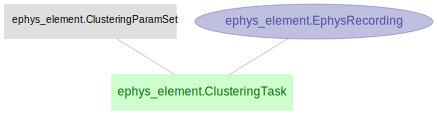

In [87]:
dj.Diagram(ephys_element.EphysRecording) + ephys_element.ClusteringParamSet + ephys_element.ClusteringTask

In [88]:
# insert clustering task manually
params_ks = {
    "fs": 30000,
    "fshigh": 150,
    "minfr_goodchannels": 0.1,
    "Th": [10, 4],
    "lam": 10,
    "AUCsplit": 0.9,
    "minFR": 0.02,
    "momentum": [20, 400],
    "sigmaMask": 30,
    "ThPr": 8,
    "spkTh": -6,
    "reorder": 1,
    "nskip": 25,
    "GPU": 1,
    "Nfilt": 1024,
    "nfilt_factor": 4,
    "ntbuff": 64,
    "whiteningRange": 32,
    "nSkipCov": 25,
    "scaleproc": 200,
    "nPCs": 3,
    "useRAM": 0
}
ephys_element.ClusteringParamSet.insert_new_params(
    'kilosort2', 0, 'Spike sorting using Kilosort2', params_ks)
ephys_element.ClusteringParamSet()

paramset_idx,clustering_method,paramset_desc,param_set_hash,params dictionary of all applicable parameters
0,kilosort2,Spike sorting using Kilosort2,83f93e90-d8e0-1dca-5b2c-f65e2b0b3c61,=BLOB=


We are then able to insert an entry into the `ClusteringTask` table. One important field of the table is `clustering_output_dir`, which specifies the Kilosort2 output directory for the later processing. For the current pipeline, the directory could be reconstructed from directories stored in existing tables

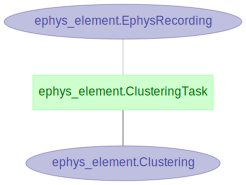

In [89]:
dj.Diagram(ephys_element.EphysRecording) + ephys_element.ClusteringTask + ephys_element.Clustering

In [90]:
ephys_element.ClusteringTask.describe();

# Manual table for defining a clustering task ready to be run
-> ephys_element.EphysRecording
-> ephys_element.ClusteringParamSet
---
clustering_output_dir : varchar(255)                 # clustering output directory relative to the clustering root data directory
task_mode="load"     : enum('load','trigger')       # 'load': load computed analysis results, 'trigger': trigger computation



In [23]:
ephys_key = dict(
    subject_fullname='ms81_M004', session_date='2021-05-07', session_number=0, insertion_number=0)
# ephys_dir = 'schottdorf/NPX/2021_01_15_E105/towersTask_g0/towersTask_g0_imec0'
ephys_dir = '210507_M004/towersTask_g0_imec0/'

In [24]:
ephys_element.ClusteringTask.insert1(
    dict(**ephys_key, paramset_idx=0, clustering_output_dir=ephys_dir), skip_duplicates=True)
ephys_element.ClusteringTask()

subject_fullname username_mouse_nickname,session_date date of experiment,session_number number,insertion_number,paramset_idx,clustering_output_dir clustering output directory relative to the clustering root data directory,"task_mode 'load': load computed analysis results, 'trigger': trigger computation"
hnieh_E105,2021-01-15,0,0,0,schottdorf/NPX/2021_01_15_E105/towersTask_g0/towersTask_g0_imec0,load
ms81_M004,2021-05-07,0,0,0,210507_M004/towersTask_g0_imec0/,load


We are then able to populate the clustering results. The `Clustering` table now validates the Kilosort2 outcomes. In the future release of elements-ephys, this table will be used to trigger Kilosort2.

In [95]:
ephys_element.Clustering.populate(display_progress=True)

Clustering: 100%|██████████| 1/1 [00:00<00:00, 43.29it/s]


# Curation and CuratedClustering

The next step in the pipeline is the curation of spike sorting results. If a manual curation was implemented, an entry needs to be manually inserted into the table `Curation`, which specifies the directory to the curated results in `curation_output_dir`. If we would like to process the Kilosort2 outcome directly, an entry is also needed in `Curation`. A method `create1_from_clustering_task` was provided to help this insertion. It copies the `clustering_output_dir` in `ClusteringTask` to the field `curation_output_dir` in the table `Curation` with a new `curation_id`.

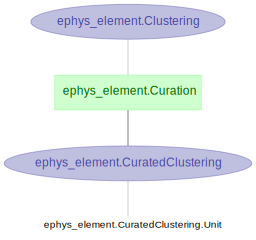

In [21]:
dj.Diagram(ephys_element.Clustering) + ephys_element.Curation + ephys_element.CuratedClustering \
+ ephys_element.CuratedClustering.Unit

In [25]:
key = (ephys_element.ClusteringTask & ephys_key).fetch1('KEY')
ephys_element.Curation().create1_from_clustering_task(key)

In [26]:
ephys_element.Curation()

subject_fullname username_mouse_nickname,session_date date of experiment,session_number number,insertion_number,paramset_idx,curation_id,curation_time time of generation of this set of curated clustering results,"curation_output_dir output directory of the curated results, relative to clustering root data directory",quality_control has this clustering result undergone quality control?,manual_curation has manual curation been performed on this clustering result?,curation_note
hnieh_E105,2021-01-15,0,0,0,1,2021-02-21 23:43:45,schottdorf/NPX/2021_01_15_E105/towersTask_g0/towersTask_g0_imec0,0,0,
ms81_M004,2021-05-07,0,0,0,1,2021-05-19 20:30:16,210507_M004/towersTask_g0_imec0/,0,0,
ms81_M004,2021-05-07,0,0,0,2,2021-05-19 20:30:16,210507_M004/towersTask_g0_imec0/,0,0,


Then we could populate table `CuratedClustering`, ingesting either the output of Kilosort2 or the curated results.

In [27]:
ephys_element.CuratedClustering.populate(display_progress=True)

CuratedClustering:   0%|          | 0/1 [00:00<?, ?it/s]/Users/ms81/opt/anaconda3/lib/python3.8/site-packages/element_array_ephys/readers/kilosort.py:141: RuntimeWarning: invalid value encountered in true_divide
  self._data['spike_depths'] = (np.sum(spk_feature_ycoord * pc_features**2, axis=1)
CuratedClustering: 100%|██████████| 1/1 [00:28<00:00, 28.04s/it]


The part table `CuratedClustering.Unit` contains the spike sorted units

In [28]:
ephys_element.CuratedClustering.Unit() & ephys_key

subject_fullname username_mouse_nickname,session_date date of experiment,session_number number,insertion_number,paramset_idx,curation_id,unit,electrode_config_hash,probe_type e.g. neuropixels_1.0,"electrode electrode index, starts at 0",cluster_quality_label,spike_count how many spikes in this recording for this unit,"spike_times (s) spike times of this unit, relative to the start of the EphysRecording",spike_sites array of electrode associated with each spike,"spike_depths (um) array of depths associated with each spike, relative to the (0, 0) of the probe"
ms81_M004,2021-05-07,0,0,0,1,0,6f6d8149-1603-9d2c-f884-0fdf995ec8b3,neuropixels 1.0 - 3B,9,mua,29402,=BLOB=,=BLOB=,=BLOB=
ms81_M004,2021-05-07,0,0,0,1,1,6f6d8149-1603-9d2c-f884-0fdf995ec8b3,neuropixels 1.0 - 3B,13,good,28189,=BLOB=,=BLOB=,=BLOB=
ms81_M004,2021-05-07,0,0,0,1,2,6f6d8149-1603-9d2c-f884-0fdf995ec8b3,neuropixels 1.0 - 3B,18,good,99,=BLOB=,=BLOB=,=BLOB=
ms81_M004,2021-05-07,0,0,0,1,3,6f6d8149-1603-9d2c-f884-0fdf995ec8b3,neuropixels 1.0 - 3B,18,mua,6563,=BLOB=,=BLOB=,=BLOB=
ms81_M004,2021-05-07,0,0,0,1,4,6f6d8149-1603-9d2c-f884-0fdf995ec8b3,neuropixels 1.0 - 3B,20,mua,22246,=BLOB=,=BLOB=,=BLOB=
ms81_M004,2021-05-07,0,0,0,1,5,6f6d8149-1603-9d2c-f884-0fdf995ec8b3,neuropixels 1.0 - 3B,23,mua,21093,=BLOB=,=BLOB=,=BLOB=
ms81_M004,2021-05-07,0,0,0,1,6,6f6d8149-1603-9d2c-f884-0fdf995ec8b3,neuropixels 1.0 - 3B,23,mua,19780,=BLOB=,=BLOB=,=BLOB=
ms81_M004,2021-05-07,0,0,0,1,7,6f6d8149-1603-9d2c-f884-0fdf995ec8b3,neuropixels 1.0 - 3B,23,mua,23441,=BLOB=,=BLOB=,=BLOB=
ms81_M004,2021-05-07,0,0,0,1,8,6f6d8149-1603-9d2c-f884-0fdf995ec8b3,neuropixels 1.0 - 3B,23,mua,24981,=BLOB=,=BLOB=,=BLOB=
ms81_M004,2021-05-07,0,0,0,1,9,6f6d8149-1603-9d2c-f884-0fdf995ec8b3,neuropixels 1.0 - 3B,26,good,10489,=BLOB=,=BLOB=,=BLOB=


# Sync behavior

In [29]:
ephys.BehaviorSync.populate()

In [32]:
ephys.CuratedClustersIteration.populate()

DataJointError: fetch1 should only return one tuple. 0 tuples found

## Populate LFP and waveform

In [ ]:
ephys_element.LFP.populate(display_progress=True)

In [41]:
ephys_element.LFP()

subject_fullname username_mouse_nickname,session_date date of experiment,session_number number,insertion_number,lfp_sampling_rate (Hz),lfp_time_stamps (s) timestamps with respect to the start of the recording (recording_timestamp),"lfp_mean (uV) mean of LFP across electrodes - shape (time,)"
hnieh_E105,2021-01-15,0,0,2500.05,=BLOB=,=BLOB=


The current workflow also contain tables to save spike waveforms:

`WaveformSet`: a table to drive the processing of all spikes waveforms resulting from a CuratedClustering.  
`WaveformSet.Waveform`: mean waveform across spikes for a given unit and electrode.  
`WaveformSet.PeakWaveform`: mean waveform across spikes for a given unit at the electrode with peak spike amplitude.

In [2]:
# May take a while to populate depending on data size.
ephys_element.WaveformSet.populate(display_progress=True)

WaveformSet: 100%|██████████| 1/1 [20:01<00:00, 1201.35s/it]


TODO: 
    - Sync table under ephys module.
    - Unit table could contain the clustering results for multiple sorters. U19 team needs to implemnt the workflow for other sorters by overwriting the make function of the table `ephys_element.Clustering`. e.g.
    ```
    def ironclust_make(key):
    if (ephys_element.ClusteringMethod & key).fetch1('clustering_method') != 'ironclust':
        return
    pass
    ephys_element.CuratedClustering.make = ironclust_make
    ephys_element.CuratedClustering.populate()
    ```